# Import các package cần thiết

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve

# Đọc dữ liệu

In [5]:
df = pd.read_csv('/kaggle/input/tehran-house-prices-dataset/TehranHouse.csv')

df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67
3475,83,2,True,True,True,Niavaran,6.800000e+09,226666.67
3476,75,2,False,False,False,Parand,3.650000e+08,12166.67
3477,105,2,True,True,True,Dorous,5.600000e+09,186666.67


# Xử lý dữ liệu

In [6]:
#Xóa các hàng trùng lặp
df.drop_duplicates(inplace=True)
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
...,...,...,...,...,...,...,...,...
3473,63,1,True,True,False,Feiz Garden,1.890000e+09,63000.00
3474,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67
3475,83,2,True,True,True,Niavaran,6.800000e+09,226666.67
3477,105,2,True,True,True,Dorous,5.600000e+09,186666.67


In [7]:
#Kiểm tra dữ liệu xem có hàng nào chứa giá trị Null không
#Nếu có thì xóa
missing_values = df.isnull().sum()

if missing_values.any():
  df.dropna(inplace=True)

missing_values, df

(Area           0
 Room           0
 Parking        0
 Warehouse      0
 Elevator       0
 Address       23
 Price          0
 Price(USD)     0
 dtype: int64,
      Area  Room  Parking  Warehouse  Elevator             Address  \
 0      63     1     True       True      True             Shahran   
 1      60     1     True       True      True             Shahran   
 2      79     2     True       True      True              Pardis   
 3      95     2     True       True      True       Shahrake Qods   
 4     123     2     True       True      True      Shahrake Gharb   
 ...   ...   ...      ...        ...       ...                 ...   
 3473   63     1     True       True     False         Feiz Garden   
 3474   86     2     True       True      True  Southern Janatabad   
 3475   83     2     True       True      True            Niavaran   
 3477  105     2     True       True      True              Dorous   
 3478   82     2    False       True      True              Parand   
 

In [8]:
del missing_values

In [9]:
#Vì Area đang ở type Object nên ta sẽ chuyển về integer
df["Area"]=df["Area"].apply(lambda x : re.sub(',' , '', x))
df["Area"]=pd.to_numeric(df["Area"])
df.dtypes

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

In [10]:
#Xử lý giá trị ngoại biên bằng IQR
def lower_and_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

area_lower, area_upper = lower_and_upper(df['Area'])
price_lower, price_upper = lower_and_upper(df['Price'])

df = df[(df['Area'] >= area_lower) & (df['Area'] <= area_upper)]
df = df[(df['Price'] >= price_lower) & (df['Price'] <= price_upper)]

df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
...,...,...,...,...,...,...,...,...
3473,63,1,True,True,False,Feiz Garden,1.890000e+09,63000.00
3474,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67
3475,83,2,True,True,True,Niavaran,6.800000e+09,226666.67
3477,105,2,True,True,True,Dorous,5.600000e+09,186666.67


In [11]:
del area_lower, area_upper, price_lower, price_upper

In [12]:
top_values = df['Address'].value_counts().nlargest(20).index

# Lọc DataFrame chỉ chứa các giá trị ở cột Address nằm trong top 20 lần xuất hiện
df = df[df['Address'].isin(top_values)]

df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
...,...,...,...,...,...,...,...,...
3468,81,2,True,True,True,West Ferdows Boulevard,4.455000e+09,148500.00
3470,97,2,True,True,True,Shahran,2.700000e+09,90000.00
3472,113,3,True,True,True,Ostad Moein,3.170000e+09,105666.67
3474,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67


In [13]:
del top_values

In [14]:
#Xóa cột Price vì đã có Price(USD)
#Số hóa cột Address

df.drop(columns=['Price'], inplace=True)

address_dummy = pd.get_dummies(df['Address'])
df = df.merge(address_dummy, left_index = True, right_index = True)

df.drop(columns = 'Address', inplace = True)
df

/tmp/ipykernel_36/3874699456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Price'], inplace=True)


,Area,Room,Parking,Warehouse,Elevator,Price(USD),Andisheh,Central Janatabad,East Ferdows Boulevard,Gheitarieh,...,Pirouzi,Punak,Saadat Abad,Salsabil,Shahr-e-Ziba,Shahrake Gharb,Shahrake Qods,Shahran,Southern Janatabad,West Ferdows Boulevard
0,63,1,True,True,True,61666.67,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,60,1,True,True,True,61666.67,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,79,2,True,True,True,18333.33,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95,2,True,True,True,30083.33,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,123,2,True,True,True,233333.33,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,81,2,True,True,True,148500.00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3470,97,2,True,True,True,90000.00,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3472,113,3,True,True,True,105666.67,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3474,86,2,True,True,True,116666.67,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [15]:
#Chuyển True/False thành 1/0
boolean_features = df.columns[2:]
df[boolean_features] = df[boolean_features].astype('int64')
df

,Area,Room,Parking,Warehouse,Elevator,Price(USD),Andisheh,Central Janatabad,East Ferdows Boulevard,Gheitarieh,...,Pirouzi,Punak,Saadat Abad,Salsabil,Shahr-e-Ziba,Shahrake Gharb,Shahrake Qods,Shahran,Southern Janatabad,West Ferdows Boulevard
0,63,1,1,1,1,61666,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,60,1,1,1,1,61666,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,79,2,1,1,1,18333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,95,2,1,1,1,30083,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,123,2,1,1,1,233333,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,81,2,1,1,1,148500,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3470,97,2,1,1,1,90000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3472,113,3,1,1,1,105666,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3474,86,2,1,1,1,116666,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
del address_dummy, boolean_features

In [17]:
df.dtypes

Area                         int64
Room                         int64
Parking                      int64
Warehouse                    int64
Elevator                     int64
Price(USD)                   int64
Andisheh                     int64
Central Janatabad            int64
East Ferdows Boulevard       int64
Gheitarieh                   int64
Jeyhoon                      int64
Ostad Moein                  int64
Parand                       int64
Pardis                       int64
Pasdaran                     int64
Persian Gulf Martyrs Lake    int64
Pirouzi                      int64
Punak                        int64
Saadat Abad                  int64
Salsabil                     int64
Shahr-e-Ziba                 int64
Shahrake Gharb               int64
Shahrake Qods                int64
Shahran                      int64
Southern Janatabad           int64
West Ferdows Boulevard       int64
dtype: object

# Chuẩn bị dữ liệu

In [18]:
#Gán X cho features và y cho target
y = df['Price(USD)']
X = df.drop(columns=['Price(USD)'])
X

,Area,Room,Parking,Warehouse,Elevator,Andisheh,Central Janatabad,East Ferdows Boulevard,Gheitarieh,Jeyhoon,...,Pirouzi,Punak,Saadat Abad,Salsabil,Shahr-e-Ziba,Shahrake Gharb,Shahrake Qods,Shahran,Southern Janatabad,West Ferdows Boulevard
0,63,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,60,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,79,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,95,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,123,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,81,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3470,97,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3472,113,3,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3474,86,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
y

0        61666
1        61666
2        18333
3        30083
4       233333
         ...  
3468    148500
3470     90000
3472    105666
3474    116666
3478     12000
Name: Price(USD), Length: 1753, dtype: int64

In [20]:
#Tập train 80%, test 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train.shape, X_test.shape

((1402, 25), (351, 25))

In [21]:
#Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
del df

# MODEL0 | Chưa áp dụng các best-practices.

In [23]:
model0 = LinearRegression()
model0.fit(X_train, y_train)

LinearRegression()

In [24]:
y_hat = model0.predict(X_test)

MSE0 = mean_squared_error(y_test , y_hat)
MinMSE = MSE0

print('MSE =', MSE0)

MSE = 1229600811.165739


In [25]:
train_MSE0 = mean_squared_error(y_train, model0.predict(X_train))
test_MSE0 = mean_squared_error(y_test, model0.predict(X_test))

# MODEL1 | Áp dụng Regularization

In [26]:
lambda_ = [a for a in range(1,100)]
MSElist = []
for i in lambda_:
  model1 = Ridge(alpha=i) #Regularization L2. alpha ở đây tương đương với lambda.
  model1.fit(X_train, y_train)

  y_hat = model1.predict(X_test)
  MSE1 = mean_squared_error(y_test , y_hat)
  MSElist.append(MSE1)

  if MSE1 < MinMSE:
    MinMSE = MSE1
  print(f'Tại lambda = {i} mô hình có MSE là: {MSE1}')

print(f'\MSE1 hiện tại là: {MinMSE}. Giảm {MSE0 - MinMSE} đơn vị so mới MODEL0')

Tại lambda = 1 mô hình có MSE là: 1228904321.0793839
Tại lambda = 2 mô hình có MSE là: 1228225547.462451
Tại lambda = 3 mô hình có MSE là: 1227564232.2466626
Tại lambda = 4 mô hình có MSE là: 1226920122.3750865
Tại lambda = 5 mô hình có MSE là: 1226292969.6838713
Tại lambda = 6 mô hình có MSE là: 1225682530.787227
Tại lambda = 7 mô hình có MSE là: 1225088566.9655252
Tại lambda = 8 mô hình có MSE là: 1224510844.0564525
Tại lambda = 9 mô hình có MSE là: 1223949132.3490968
Tại lambda = 10 mô hình có MSE là: 1223403206.4808962
Tại lambda = 11 mô hình có MSE là: 1222872845.337348
Tại lambda = 12 mô hình có MSE là: 1222357831.9544096
Tại lambda = 13 mô hình có MSE là: 1221857953.4234908
Tại lambda = 14 mô hình có MSE là: 1221373000.7989798
Tại lambda = 15 mô hình có MSE là: 1220902769.0082092
Tại lambda = 16 mô hình có MSE là: 1220447056.7638009
Tại lambda = 17 mô hình có MSE là: 1220005666.4783103
Tại lambda = 18 mô hình có MSE là: 1219578404.1811087
Tại lambda = 19 mô hình có MSE là: 12191

In [27]:
train_MSE1 = mean_squared_error(y_train, model1.predict(X_train))
test_MSE1 = mean_squared_error(y_test, model1.predict(X_test))

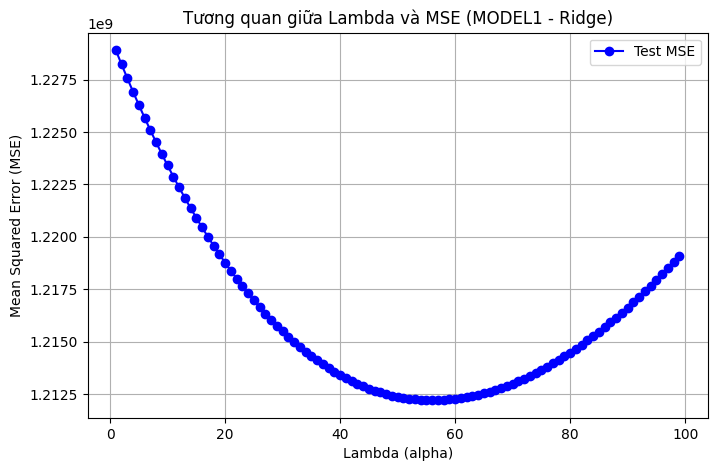

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(lambda_, MSElist, marker='o', linestyle='-', color='b', label="Test MSE")

plt.xlabel("Lambda (alpha)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Tương quan giữa Lambda và MSE (MODEL1 - Ridge)")
plt.legend()
plt.grid(True)
plt.show()

# MODEL2 | Áp dụng Regularization và Polynomial

In [29]:
MSEList1 = []
for j in range(1, 4):  #Bậc chạy tự 1 tới 3
  model2 = Pipeline([
      ('poly', PolynomialFeatures(degree=j)),
      ('ridge', Ridge(alpha=45))               #Chọn lambda = 45 vì đã đạt tối ưu ở MODEL1
  ])
  model2.fit(X_train, y_train)

  y_hat = model2.predict(X_test)
  MSE2 = mean_squared_error(y_test , y_hat)
  MSEList1.append(MSE2)
  if MSE2 < MinMSE:
    MinMSE = MSE2

  print(f'Tại lambda = {45}, bậc = {j} có MSE = {MSE2}')
print(f'\nMin MSE hiện tại là: {MinMSE}. Giảm {MSE1 - MinMSE} đơn vị so với MODEL1')

Tại lambda = 45, bậc = 1 có MSE = 1212760698.6644115
Tại lambda = 45, bậc = 2 có MSE = 745108169.0063906
Tại lambda = 45, bậc = 3 có MSE = 750913838.3394976

Min MSE hiện tại là: 745108169.0063906. Giảm 473971334.6563997 đơn vị so với MODEL1


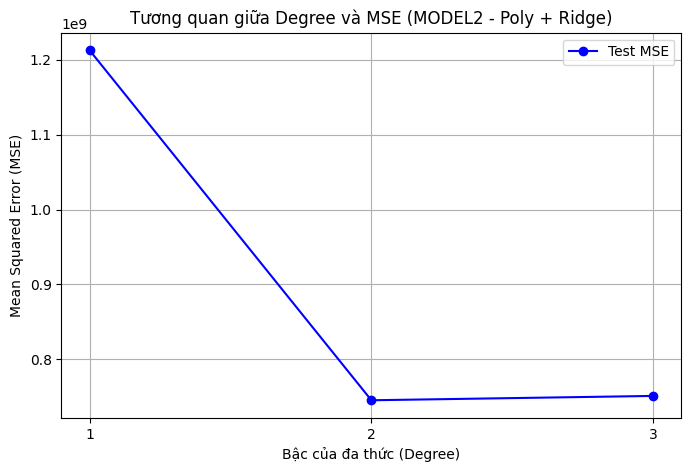

In [30]:


plt.figure(figsize=(8, 5))
plt.plot([1,2,3], MSEList1, marker='o', linestyle='-', color='b', label="Test MSE")

plt.xlabel("Bậc của đa thức (Degree)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Tương quan giữa Degree và MSE (MODEL2 - Poly + Ridge)")
plt.xticks([1,2,3])
plt.legend()
plt.grid(True)
plt.show()


In [31]:
train_MSE2 = mean_squared_error(y_train, model2.predict(X_train))
test_MSE2 = mean_squared_error(y_test, model2.predict(X_test))

# MODEL3 | Áp dụng Hyperparameter tuning

In [32]:
model3 = Pipeline([
        ('poly', PolynomialFeatures()),
        ('SGD', SGDRegressor(max_iter=5000))
    ])

In [33]:
#Các hyperparameters tối ưu sẽ được tự động tìm trên tập CV.
param_grid = {
    'poly__degree': [1, 2, 3],
    'SGD__alpha': np.logspace(-4, 2, 7),
    'SGD__learning_rate': ['optimal', 'invscaling'],
    'SGD__eta0': [0.001, 0.01, 0.1]
}


In [34]:
grid_search = GridSearchCV(model3, param_grid, cv=5)

grid_search.fit(X_train, y_train)
y_hat = grid_search.predict(X_test)
MSE3 = mean_squared_error(y_test, y_hat)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stocha

In [35]:
print(f'MSE = {MSE3}, giảm {MSE3 - MinMSE} so với MinMSE')

MSE = 830138876.1101915, giảm 85030707.1038009 so với MinMSE


In [36]:
train_MSE3 = mean_squared_error(y_train, grid_search.predict(X_train))
test_MSE3 = mean_squared_error(y_test, grid_search.predict(X_test))

In [37]:
joblib.dump(grid_search, 'linear_model.joblib')

r2 = r2_score(y_test, y_hat)
print(f"R² score: {r2:.4f}")

R² score: 0.9076
